# QC of TMT labeled proteome data 
## searched with MaxQuant v.1.6.10.43 with unitprot reviewed mouse DB, without isoforms, with PIF cutoff (0.75) and iBAQ calculation enabled

### Author: Konstantin Kahnert
### Date: 2020_09_09

### Load required libraries


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Define required functions

In [2]:
def calculate_missed_cleavage_rate(path_peptides):
    """
    calculates the fraction of peptides with one or two missed cleavages

    input: peptides.txt

    returns: (total MC rate, 1 MC rate, 2 MC rate)
    """
    # # load data into a pandas dataframe
    df_peptides = pd.read_table(path_peptides)

    # # count number of missed cleavages
    num_MC = df_peptides["Missed cleavages"].value_counts()

    # # calculate MC rates
    total_MC_rate = (num_MC[1] + num_MC[2]) / sum(num_MC) * 100
    MC_rate_1 = num_MC[1] / sum(num_MC) * 100
    MC_rate_2 = num_MC[2] / sum(num_MC) * 100

    return [total_MC_rate, MC_rate_1, MC_rate_2]


def calculate_percent_cysteines(path_peptides):
    """
    calculates the percentage of cysteines based on MaxQuant output file 'peptides.txt'
    input: peptides.txt

    returns: fraction of peptides with a cysteine
    """
    # # load data into a pandas dataframe
    df_peptides = pd.read_table(path_peptides)

    # # count number peptides
    num_peptides = len(df_peptides)

    # # count number of peptide containing a C
    num_peptide_C = sum(df_peptides["Sequence"].apply(lambda x: "C" in x))

    # # calculate fraction of peptides containing a C
    C_fraction = num_peptide_C / num_peptides * 100

    return C_fraction


def plot_density_curves(df, title=""):
    """
    Takes a data frame and plots the density curve of each column into one plot

    input: pandas dataframe (all columns are plotted)
    title: str, title of the plot

    returns: figure
    """
    # set plot style to white background
    sns.set_style("white")

    # create new figure
    fig = plt.figure(figsize=(8, 8))

    # iterate through all samples
    for sample in df.columns:

        # extract column of given sample
        df_sample = df[sample]

        # draw density curve
        sns.distplot(df_sample, hist=False, kde=True, kde_kws={'linewidth': 1}, label=sample)

    # Plot formatting
    plt.legend(prop={'size': 8, "weight": "bold"}, title='Sample')
    plt.title(title)
    plt.xlabel('log2(Intensity)', weight="bold")
    plt.ylabel('Density', weight="bold")

    return fig


def plot_sample_correlation(df, title=""):
    """
    Calculates pearson correlations between samples and visualizes them by plotting a heat map

    input: pandas dataframe (all columns are plotted)
    title: str, title of the plot

    returns: figure
    """
    # # calculate pearson correlation matrix
    df_corr = df.corr(method="pearson")

    # # create mask to only show lower right triangle of the heatmap
    # create matrix containing only zeros of same dimension as df_proteinGroups_log_corr
    mask = np.zeros_like(df_corr)

    # set values of upper right triangle to ones (fields with 1 will not be displayed in the plot)
    mask[np.triu_indices_from(mask)] = True

    # invert the matrix (so that the diagonal is not covered)
    # and flip it around so that so upper left triangle is covered (=1)
    mask = np.invert(mask.astype(bool)).astype(int)[::-1]

    # # create heatmap to visualize the pearson correlations
    # change font size
    sns.set(font_scale=1.1)

    # set style
    with sns.axes_style("white"):
        # initialize new figure
        fig, ax = plt.subplots(figsize=(8, 6))

        # plot heatmap and use mask to cover upper left triangle and color bar on the left side
        ax = sns.heatmap(df_corr[::-1], linewidths=.5, annot=True, mask=mask, square=True,
                         cmap="Reds", vmin=0.8, vmax=1, cbar_kws=dict(use_gridspec=False, location="left",
                                                                      anchor=(1.65, 0.5)))

        # move y axis ticks to the right side of the plot
        ax.yaxis.tick_right()

        # rotate y tick labels to be displayed horizontally
        plt.yticks(rotation='horizontal')

        # set y axis label
        plt.ylabel("Pearson Correlation", weight="bold", fontsize=15)

        # move y axis label to the left to not overlap with the color bar
        ax.yaxis.set_label_coords(-0.25, 0.5)

        # display x axis ticks
        ax.xaxis.tick_bottom()

        # rotate x tick labels to be displayed in a 45 degree angle
        plt.xticks(rotation=45)

        # change tick label size
        ax.tick_params(axis='both', which='major', labelsize=12)

        # set x axis lable
        plt.xlabel("Sample", weight="bold", fontsize=15)

        # add title
        plt.suptitle(title, weight="bold", fontsize=15)

        return fig


def plot_boxplot(df, title="Intensities per Sample"):
    """
    Not finished yet!

    Creates a box and whisker plot

    returns: figure
    """
    # create nnew figure
    fig, ax = plt.subplots(figsize=(11, 6))

    # plot boxplot
    sns.boxplot(x="Sample", y="Intensity", data=df,
                hue="Group", palette="Set1", width=1.2, ax=ax, notch=True)

    # set x axis limits
    plt.xlim(-1, 10)

    # move legend outside of the plot area
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title="Group")

    # set axis labels
    plt.xlabel("Sample", weight="bold")
    plt.ylabel("log2(Intensity)", weight="bold")

    # add title
    plt.title(title, weight="bold")

    return fig


def save_figure(fig, name):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None


###  Specify location of the MaxQuant proteinGroups.txt file and use it to generate the path of the required files


In [3]:
# specify location of the MaxQuant proteinGroups.txt file
path_txt_folder = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Proteome\Analysis\canonical\w_PIF\01_QC\combined\txt"

# # set paths for required files (don't change this)
path_proteinGroups = path_txt_folder + r"\proteinGroups.txt"
path_evidence = path_txt_folder + r"\evidence.txt"
path_peptides= path_txt_folder + r"\peptides.txt"
path_summary = path_txt_folder + r"\summary.txt"

# set path for output
folder_output = path_txt_folder

### Specifiy which labels/channels were used for which samples
In MaxQuant the column of interest for the further analysis is the "Reporter intensity corrected [1-10]" for a TMT 10plex experiment. Numbers are corresponding to the different labels as specified below.

In [4]:
# don't change this
MQ_channels_to_TMT_labels = {"1": "126C", "2": "127N", "3": "127C", "4": "128N", "5": "128C",
                              "6": "129N", "7": "129C", "8": "130N", "9": "130C", "10": "131N"}

# change this to your sample identifiers
TMT_labels_to_samples = {"126C": 'Sham 1', '127N': 'Sham 2', '127C': 'Sham 3', '128N': 'Sham 4', '128C': 'Sham 5',
                          '129N': 'TAC 1', '129C': 'TAC 2', '130N': 'TAC 3', '130C': 'TAC 4', '131N': 'TAC 5'}

### Load proteinGroups.txt file into a pandas dataframe and set Majority protein ID's column as index


In [5]:
# load data into a pandas dataframe
df_proteinGroups = pd.read_table(path_proteinGroups)

# create protein/gene column
protein_col = df_proteinGroups["Majority protein IDs"].astype(str)

# set protein_gene_col column as index
df_proteinGroups.set_index(protein_col, inplace=True)

# show head of df 
df_proteinGroups.head(5)

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
Majority protein IDs,,,,,,,,,,,,,,,,,,,,,
P0DPB4;A0A088MLT8,P0DPB4;A0A088MLT8,P0DPB4;A0A088MLT8,7;7,7;7,7;7,NaN,Schip1,SCHI1_MOUSE Schwannomin-interacting protein 1 ...,2,7,...,NaN,0,6069;8344;8870;13813;19817;31684;39687,True;True;True;True;True;True;True,6333;8706;9250;9251;14422;20662;33317;41657,17467;17468;24091;25559;25560;25561;25562;2556...,11890;16386;17364;17365;17366;17367;17368;2768...,11890;16386;17367;27682;38853;60572;75514,0,352
A1IGU4,A1IGU4,A1IGU4,2,2,2,Rho guanine nucleotide exchange factor 37,Arhgef37,ARH37_MOUSE Rho guanine nucleotide exchange fa...,1,2,...,NaN,1,778;11538,True;True,820;12039,2480;33723,1660;23120,1660;23120,NaN,NaN
A1L314,A1L314,A1L314,1,1,1,Macrophage-expressed gene 1 protein,Mpeg1,MPEG1_MOUSE Macrophage-expressed gene 1 protei...,1,1,...,NaN,2,8075,True,8429,23393,15915,15915,NaN,NaN
A2A432,A2A432,A2A432,10,6,6,Cullin-4B,Cul4b,CUL4B_MOUSE Cullin-4B OS=Mus musculus OX=10090...,1,10,...,NaN,3,6875;9957;9997;19846;21301;24900;30715;32041;3...,True;True;True;True;False;True;True;False;Fals...,7170;10392;10433;20691;22201;25922;32320;33686...,20019;20020;28865;28866;29007;56623;60447;6044...,13630;13631;19648;19649;19743;38911;41620;4162...,13630;19649;19743;38911;41621;48121;59030;6127...,NaN,NaN
A2A4P0,A2A4P0,A2A4P0,1,1,1,ATP-dependent RNA helicase DHX8,Dhx8,DHX8_MOUSE ATP-dependent RNA helicase DHX8 OS=...,1,1,...,NaN,4,8983,True,9368,25874,17584,17584,NaN,NaN


### Count total number of proteins

In [6]:
# count total number of proteins
num_proteins_total = len(df_proteinGroups)
print(num_proteins_total)

7009


### Count the number of decoys, contaminants and only identified by site hits and remove them

In [7]:
# count number of decoys, contaminats and only identified by site
num_decoys = len(df_proteinGroups[df_proteinGroups["Reverse"] == "+"])
num_contaminats = len(df_proteinGroups[df_proteinGroups["Potential contaminant"] == "+"])
num_id_by_site = len(df_proteinGroups[df_proteinGroups["Only identified by site"] == "+"])

# remove decoys, contaminats and only identified by site identifications
df_proteinGroups = df_proteinGroups[df_proteinGroups["Reverse"] != "+"]
df_proteinGroups = df_proteinGroups[df_proteinGroups["Potential contaminant"] != "+"]
df_proteinGroups = df_proteinGroups[df_proteinGroups["Only identified by site"] != "+"]

print(num_decoys, num_contaminats, num_id_by_site)

88 42 53


### Reduce the dataframe to the columns of interest (Reporter intensity corrected [1-10])

In [8]:
# remove all unnecessary columns, i.e. just keep "Reporter intensity corrected [1-10]" columns
df_proteinGroups_reduced = df_proteinGroups.filter(regex="Reporter intensity corrected")

df_proteinGroups_reduced.head(5)

,Reporter intensity corrected 1 HF SN,Reporter intensity corrected 2 HF SN,Reporter intensity corrected 3 HF SN,Reporter intensity corrected 4 HF SN,Reporter intensity corrected 5 HF SN,Reporter intensity corrected 6 HF SN,Reporter intensity corrected 7 HF SN,Reporter intensity corrected 8 HF SN,Reporter intensity corrected 9 HF SN,Reporter intensity corrected 10 HF SN
Majority protein IDs,,,,,,,,,,
P0DPB4;A0A088MLT8,77142.0,54204.0,71221.0,72740.0,51789.0,87236.0,105130.0,69398.0,53671.0,77911.0
A1IGU4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1L314,4605.9,3227.5,3399.6,4228.9,2730.9,16496.0,10844.0,6759.5,5766.4,12979.0
A2A432,83036.0,60061.0,92336.0,123760.0,61916.0,157910.0,185550.0,73059.0,98606.0,151690.0
A2A4P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Map columns to sample and rename columns
This uses the information provided in TMT_labels_to_samples and the preset info in MQ_channels_to_TMT_labels to rename the "Reporter intensity corrected [1-10]" columns to "RIc " + provided sample names, e.g. "RIc SN 1"

In [9]:
new_cols = []
# iterate through all column names
for col in df_proteinGroups_reduced.columns:

    # extract TMT label number from column name
    number = re.findall("[0-9]+", col)[0]

    # look up TMT label by MaxQuant channel number
    label = MQ_channels_to_TMT_labels[number]

    # look up sample name by TMT label
    sample = TMT_labels_to_samples[label]

    # create new column name with using the sample name
    new_cols.append(sample)

# rename columns
df_proteinGroups_reduced.columns = new_cols
    
df_proteinGroups_reduced.head(5)

,Sham 1,Sham 2,Sham 3,Sham 4,Sham 5,TAC 1,TAC 2,TAC 3,TAC 4,TAC 5
Majority protein IDs,,,,,,,,,,
P0DPB4;A0A088MLT8,77142.0,54204.0,71221.0,72740.0,51789.0,87236.0,105130.0,69398.0,53671.0,77911.0
A1IGU4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1L314,4605.9,3227.5,3399.6,4228.9,2730.9,16496.0,10844.0,6759.5,5766.4,12979.0
A2A432,83036.0,60061.0,92336.0,123760.0,61916.0,157910.0,185550.0,73059.0,98606.0,151690.0
A2A4P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Count how many proteins in each samples were identified but not quantified and remove proteins that were not quantified in all samples

In [10]:
# replace zeros by NaN
df_proteinGroups_reduced.replace(0, np.nan, inplace=True)

# count how many proteins weren't quantified in all samples and remove them
num_before = len(df_proteinGroups_reduced)
df_proteinGroups_reduced = df_proteinGroups_reduced.dropna(how="all")
num_after = len(df_proteinGroups_reduced)
num_invalid_values_for_all = num_before - num_after

# for each sample, count how many proteins weren't quantified in sample but at least in one other sample
num_invalid_values = df_proteinGroups_reduced.isna().sum()

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


### Print summary of the previous analysis and filtering

In [11]:
# create text
stats = "The proteinGroups.txt file contains " + str(num_proteins_total) + " Proteins in total. \n" \
        "Of those: \n" + str(num_decoys) + " Proteins are decoy hits, \n" \
        + str(num_contaminats) + " Proteins are potential contaminants, \n" \
        + str(num_id_by_site) + " Proteins are only identified by site, \n" \
        "and " + str(num_invalid_values_for_all) + " Proteins were not quantified in any of the samples. \n\n" \
        "After filtering, " + str(num_after) + " Proteins valid remain, \nwith the following numbers of missing " \
        "values per sample: \n" + str(num_invalid_values)[:-12]

# print text
print(stats)

The proteinGroups.txt file contains 7009 Proteins in total. 
Of those: 
88 Proteins are decoy hits, 
42 Proteins are potential contaminants, 
53 Proteins are only identified by site, 
and 443 Proteins were not quantified in any of the samples. 

After filtering, 6406 Proteins valid remain, 
with the following numbers of missing values per sample: 
Sham 1     7
Sham 2    19
Sham 3     9
Sham 4     7
Sham 5    18
TAC 1      1
TAC 2      3
TAC 3      6
TAC 4     14
TAC 5      3



### Determining missed cleavage rate

In [12]:
MC_rates = calculate_missed_cleavage_rate(path_peptides)

#print text describing missed cleavage rates
text_MC = str(round(MC_rates[0], 1)) + " % of the peptides have missed cleavages.\n" + \
   str(round(MC_rates[1], 1)) + " % of the peptides have one missed cleavages.\n" + \
   str(round(MC_rates[2], 1)) + " % of the peptides have two missed cleavages.\n"

print(text_MC)

8.1 % of the peptides have missed cleavages.
7.9 % of the peptides have one missed cleavages.
0.3 % of the peptides have two missed cleavages.



### Determining cysteine alkylation efficiency


In [13]:
cystein_frac = calculate_percent_cysteines(path_peptides)

### print text describing cysteine fraction
text_C_frac = str(round(cystein_frac, 1)) + " % of the peptides have at least one cysteine.\n"
print(text_C_frac)

14.9 % of the peptides have at least one cysteine.



### Get MS/MS spectra number, identification rates and number of peptides identified


In [14]:
# load summary.txt to pandas dataframe
df_summary = pd.read_table(path_summary, index_col=0)

# extract number of recordes spectra
num_spectra = df_summary["MS/MS"]

# extract ID rates
ID_rate = df_summary["MS/MS Identified [%]"]

# extract number of peptides identified
num_peptides = df_summary["Peptide Sequences Identified"]

# print text showing results
text_summary = str(num_spectra["Total"]) + " spectra have been recorded of which\n" + \
   str(round(ID_rate["Total"], 2)) + " % have been identified in total.\n\n" + \
   str(num_peptides["Total"]) + " Peptides have been identified in total."

print(text_summary)

402662 spectra have been recorded of which
19.0 % have been identified in total.

42538 Peptides have been identified in total.


### Save results as report to txt file

In [15]:
# create new path name for saving results
path_report = folder_output + "\\QC_report.txt"

# open file
with open(path_report, "w") as text_file:
    print("Data QC Report\n\n", file=text_file)
    print("Summary\n", file=text_file)
    print(stats + "\n\n", file=text_file)
    print("Digestion efficiency\n", file=text_file)
    print(text_MC + "\n\n", file=text_file)
    print("Alcylation efficiency\n", file=text_file)
    print(text_C_frac + "\n\n", file=text_file)
    print("Identification rate\n", file=text_file)
    print(text_summary, file=text_file)
    
# print full report
print("Data QC Report\n\n")
print("Summary\n")
print(stats + "\n\n")
print("Digestion efficiency\n")
print(text_MC + "\n\n")
print("Alcylation efficiency\n")
print(text_C_frac + "\n\n")
print("Identification rate\n")
print(text_summary)

Data QC Report


Summary

The proteinGroups.txt file contains 7009 Proteins in total. 
Of those: 
88 Proteins are decoy hits, 
42 Proteins are potential contaminants, 
53 Proteins are only identified by site, 
and 443 Proteins were not quantified in any of the samples. 

After filtering, 6406 Proteins valid remain, 
with the following numbers of missing values per sample: 
Sham 1     7
Sham 2    19
Sham 3     9
Sham 4     7
Sham 5    18
TAC 1      1
TAC 2      3
TAC 3      6
TAC 4     14
TAC 5      3



Digestion efficiency

8.1 % of the peptides have missed cleavages.
7.9 % of the peptides have one missed cleavages.
0.3 % of the peptides have two missed cleavages.



Alcylation efficiency

14.9 % of the peptides have at least one cysteine.



Identification rate

402662 spectra have been recorded of which
19.0 % have been identified in total.

42538 Peptides have been identified in total.


## Visualization

### Visualize intensity distribution of all samples

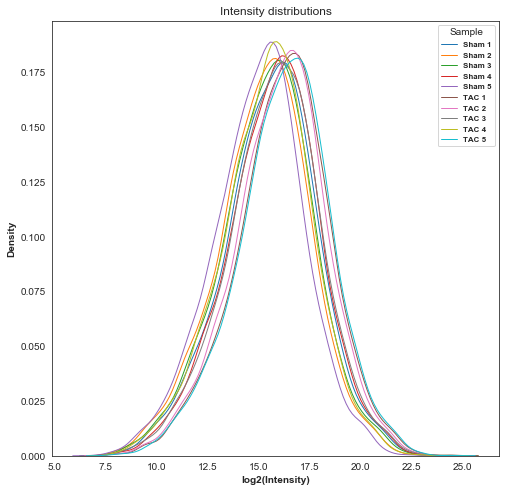

In [16]:
# log2 transform intensities
df_proteinGroups_log = df_proteinGroups_reduced.apply(np.log2)

# plot density curves
density_plot = plot_density_curves(df_proteinGroups_log, title="Intensity distributions")

save_figure(density_plot, "intensity_distribution_plot")


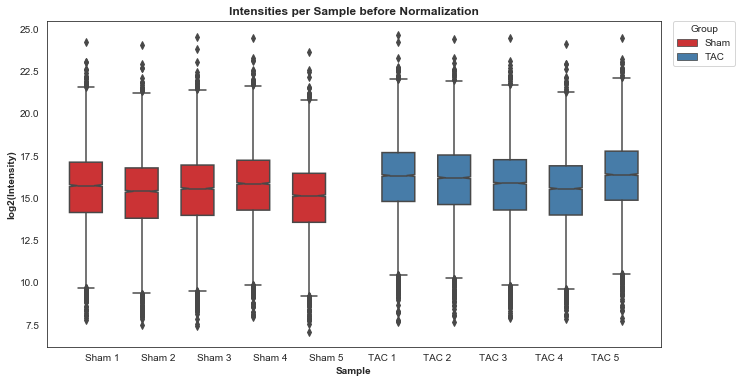

In [17]:
# plot boxplots of intensities per sample
# create dictionary mapping samples to experimental group
dict_samples = {'Sham 1': 'Sham', 'Sham 2': 'Sham', 'Sham 3': 'Sham', 'Sham 4': 'Sham', 'Sham 5': 'Sham',
'TAC 1': 'TAC', 'TAC 2': 'TAC', 'TAC 3': 'TAC', 'TAC 4': 'TAC', 'TAC 5': 'TAC'}

# melt dataframe
df_proteinGroups_log_melt = pd.melt(df_proteinGroups_log, var_name='Sample', value_name='Intensity')

# add group columns
df_proteinGroups_log_melt["Group"] = df_proteinGroups_log_melt["Sample"].map(dict_samples)

# create box plots
boxplot = plot_boxplot(df_proteinGroups_log_melt, title="Intensities per Sample before Normalization")

# save plot
save_figure(boxplot, "intensity_boxplot_before_norm")

### Visualize correlation between samples

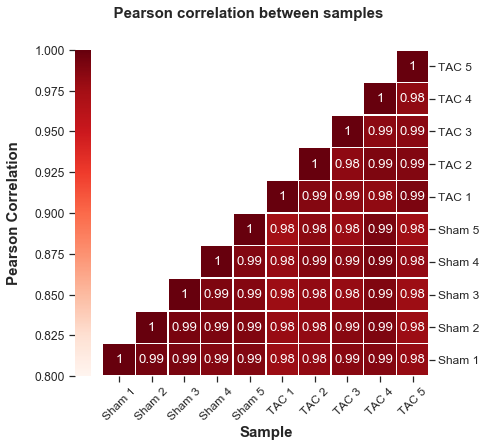

In [18]:
# # calculate pearson correlation between samples and visualize by plotting a heat map
corr_plot = plot_sample_correlation(df_proteinGroups_log, title="                    Pearson correlation between samples")

save_figure(corr_plot, "sample_correlation")

## Add all other columns that were removed earlier back to the dataframe

In [19]:
# filter df_proteinGroups for proteins that are present in df_proteinGroups_log
df_proteinGroups_filtered = df_proteinGroups[df_proteinGroups["Majority protein IDs"].isin(df_proteinGroups_log.index)]

In [20]:
# check of the order of proteins is still the same
sum(df_proteinGroups_log.index != df_proteinGroups_filtered["Majority protein IDs"])

0

In [21]:
# combine dataframe
df_proteinGroups_log.reset_index(drop=True, inplace=True)
df_proteinGroups_filtered.reset_index(drop=True, inplace=True)

df_proteinGroups_log_combined = pd.concat([df_proteinGroups_log, df_proteinGroups_filtered], axis=1)
df_proteinGroups_log_combined.head(5)

,Sham 1,Sham 2,Sham 3,Sham 4,Sham 5,TAC 1,TAC 2,TAC 3,TAC 4,TAC 5,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
0,16.235229,15.726112,16.120015,16.150461,15.660358,16.412636,16.681815,16.082606,15.711855,16.249539,...,NaN,0,6069;8344;8870;13813;19817;31684;39687,True;True;True;True;True;True;True,6333;8706;9250;9251;14422;20662;33317;41657,17467;17468;24091;25559;25560;25561;25562;2556...,11890;16386;17364;17365;17366;17367;17368;2768...,11890;16386;17367;27682;38853;60572;75514,0,352
1,12.169267,11.656201,11.731149,12.046067,11.415161,14.009829,13.404609,12.722701,12.493455,13.663892,...,NaN,2,8075,True,8429,23393,15915,15915,NaN,NaN
2,16.341449,15.874141,16.494606,16.917186,15.918025,17.268743,17.501448,16.156774,16.589388,17.210766,...,NaN,3,6875;9957;9997;19846;21301;24900;30715;32041;3...,True;True;True;True;False;True;True;False;Fals...,7170;10392;10433;20691;22201;25922;32320;33686...,20019;20020;28865;28866;29007;56623;60447;6044...,13630;13631;19648;19649;19743;38911;41620;4162...,13630;19649;19743;38911;41621;48121;59030;6127...,NaN,NaN
3,17.121412,16.715050,16.876517,17.421276,16.466777,17.763251,17.736217,17.179326,17.118373,17.975837,...,NaN,6,1341;5441;7396;8665;18925;19306;20141;20260;24...,True;True;True;True;True;True;True;True;True;T...,1410;5671;7705;9037;19738;20132;20991;21113;25...,4183;15524;21501;24914;54064;55057;57365;57366...,2828;10467;14620;16921;37137;37807;39463;39709...,2828;10467;14620;16921;37137;37807;39463;39709...,2,1
4,8.834597,9.516606,10.400239,9.944068,9.145983,10.599076,10.422065,10.017087,10.072803,10.773799,...,NaN,7,23613,True,24599,66471,45851,45851,NaN,NaN


### Save df_proteinGroups_log as csv file

In [23]:
# create new path name for saving dataframe as csv
path_df = folder_output + "\\proteinGroups_log.csv"

# write to file
df_proteinGroups_log_combined.to_csv(path_df)